# Basics

LSL also provides a high-level interface to LWA1 data through the LSL Developer Primitives (LDP) module.  First, download a small portion of the various LWA1 data formats:

In [4]:
# This may take a bit...
import os
from urllib.request import urlopen
from tempfile import mkdtemp
from lsl.reader import tbw, tbn, drx

TEMPDIR = mkdtemp()
TBW_FILE = os.path.join(TEMPDIR, 'temp.tbw')
TBN_FILE = os.path.join(TEMPDIR, 'temp.tbn')
DRX_FILE = os.path.join(TEMPDIR, 'temp.drx')
DRS_FILE = os.path.join(TEMPDIR, 'temp.drs')


fh1 = urlopen('https://fornax.phys.unm.edu/lwa/data/firstlight/firstLightTBW.dat')
fh2 = open(TBW_FILE, 'wb')
fh2.write(fh1.read(tbw.FRAME_SIZE*1000))
fh1.close()
fh2.close()
print("TBW Size: %.1f kB" % (os.path.getsize(TBW_FILE)/1024.))

fh1 = urlopen('https://lda10g.alliance.unm.edu/tutorial/Meteors/056761_000099453')
fh2 = open(TBN_FILE, 'wb')
fh2.write(fh1.read(tbn.FRAME_SIZE*1000))
fh1.close()
fh2.close()
print("TBN Size: %.1f kB" % (os.path.getsize(TBN_FILE)/1024.))

fh1 = urlopen('https://lda10g.alliance.unm.edu/tutorial/Jupiter/055917_000007389_Jupiter.dat')
fh2 = open(DRX_FILE, 'wb')
fh2.write(fh1.read(drx.FRAME_SIZE*300))
fh1.close()
fh2.close()
print("DRX Size: %.1f kB" % (os.path.getsize(DRX_FILE)/1024.))

fh1 = urlopen('https://lda10g.alliance.unm.edu/tutorial/B0329+54/056770_000044687')
fh2 = open(DRS_FILE, 'wb')
fh2.write(fh1.read(drx.FRAME_SIZE*300))
fh1.close()
fh2.close()
print("DR Spectrometer Size: %.1f kB" % (os.path.getsize(DRS_FILE)/1024.))

TBW Size: 1195.3 kB
TBN Size: 1023.4 kB
DRX Size: 1209.4 kB
DR Spectrometer Size: 1209.4 kB


Getting started with LDP is as easy as:

In [6]:
from lsl.reader.ldp import LWA1DataFile

The LWA1DataFile() function takes either a filename or an open file handle and uses the contents of the file to select the correct data format handler.  For example:

In [7]:
idfD = LWA1DataFile(DRX_FILE)
print("'temp.drx' is of type:", type(idfD))

idfS = LWA1DataFile(DRS_FILE)
print("'temp.drspec' is of type:", type(idfS))

fh = open(TBW_FILE, 'rb')
idfW = LWA1DataFile(fh=fh)
print("'temp.tbw' is of type:", type(idfW))

idfN = LWA1DataFile(TBN_FILE)
print("'temp.tbn' is of type:", type(idfN))

'temp.drx' is of type: <class 'lsl.reader.ldp.DRXFile'>
'temp.drspec' is of type: <class 'lsl.reader.ldp.DRSpecFile'>
'temp.tbw' is of type: <class 'lsl.reader.ldp.TBWFile'>
'temp.tbn' is of type: <class 'lsl.reader.ldp.TBNFile'>


As part of the initialization process LDP also takes care of preparing the file for reading, such as aligning the time tags for DRX files, and creating the ring buffer for TBN and DRX files.

LDP provides access to the file metadata through the getInfo() method.  Called without an argument, getInfo() returns a dictionary of various metadata parameters that have been determined.  Specific metadata values can be returned by specifying the parameter:

In [5]:
# Poll the TBN file for its specifics
print("TBN Metadata:")
for key in idfN.get_info().keys():
    value = idfN.get_info(key)
    print("  %s:" % key, value)
print(" ")

# Poll the DRX file for the sample rate
print("DRX Sample Rate %.3f MS/s" % (idfD.get_info('sample_rate')/1e6,))
print(" ")

# Poll the DR spectrometer file for its specifics
print("DR Spectrometer Metadata:")
for key in idfS.get_info().keys():
    value = idfS.get_info(key)
    print("  %s:" % key, value)
print(" ")

TBN Metadata:
  size: 1048000
  nframes: 1000
  frame_size: 1048
  nantenna: 520
  sample_rate: 100000.0
  data_bits: 8
  start_time: (1397472446, 0.95392)
  start_time_samples: 273904599602968320
  freq1: 37800000.66757202
 
DRX Sample Rate 19.600 MS/s
 
DR Spectrometer Metadata:
  size: 1238400
  nframes: 75
  frame_size: 16460
  beampols: 4
  beam: 2
  sample_rate: 19600000.0
  data_bits: 32
  start_time: (1398276221, 0.034108066326530614)
  start_time_samples: 274062139322685181
  freq1: 54400000.92983246
  freq2: 73999999.76158142
  nInt: 768
  tint: 0.04012408163265306
  LFFT: 1024
  nproducts: 2
  data_products: ['XX', 'YY']
 


To access the data through LDP, the most convenient method is to use the read() method of the LDP instance returned by LWA1DataFile().  This method takes in a single argument for the amount of time to read in and returns a multi-element tuple of the timestamp for the first data sample, the duration of data returned, and the data itself as a NumPy array.  For example, to read in 10 ms of raw data from a DRX file:

In [6]:
duration, tStart, data = idfD.read(0.010)
print("Duration read: %.3f ms" % (duration*1e3,))
print("Time of first sample: %.6f" % tStart)
print("Data specifics:", data.shape, data.dtype)

Duration read: 10.031 ms
Time of first sample: 1324515670.601744
Data specifics: (4, 196608) complex64


Here the duration variable holds the exact amount of data read in, the tStart variable holds the UNIX timestamp for the first sample, and the data variable is an array of the I/Q values.  The timestamp can be converted to a more easily understandable format using the datetime module:

In [7]:
tStartDT = tStart.datetime
print(tStartDT)

2011-12-22 01:01:10.601744


LDP also keeps track of the flow of time inside a data file and will raise a RuntimeError if a jump is found in the file while reading.  The behavior can be disabled by setting the "ignoreTimeTagErrors" keyword to True.

# Working with Data

The data can also be worked with in a similar fashion to that was presented in the TBN and DRX tutorials.  The LDP data handlers always return data that is explicitly ordered.  In the case of TBW and TBN data the order is by the digitizer number and for DRX it is by tuning/polarization.  For DRX data:

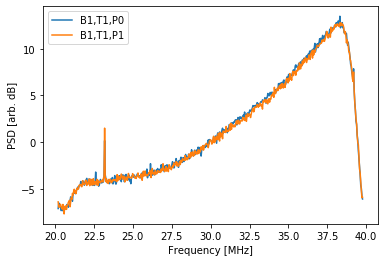

In [8]:
%matplotlib inline
import numpy
from lsl.correlator import fx as fxc
from lsl.misc.mathutils import to_dB
from matplotlib import pyplot as plt

# Compute the spectra
freq, spec = fxc.SpecMaster(data, LFFT=512, sample_rate=idfD.get_info('sample_rate'), central_freq=0.0)
freq1 = freq + idfD.get_info('freq1')
freq2 = freq + idfD.get_info('freq2')

# Plot
fig = plt.figure()
ax = fig.gca()
ax.plot(freq1/1e6, to_dB(spec[0,:]), label='B%i,T1,P0' % idfD.get_info('beam'))
ax.plot(freq1/1e6, to_dB(spec[1,:]), label='B%i,T1,P1' % idfD.get_info('beam'))
ax.set_xlabel('Frequency [MHz]')
ax.set_ylabel('PSD [arb. dB]')
ax.legend(loc=0)
plt.show()

Here the order along the first axis of data is:

  1) Tuning 1, Pol. X

  2) Tuning 1, Pol. Y

  3) Tuning 2, Pol. X

  4) Tuning 2, Pol. Y

The interface to the DR spectrometer files is slightly different since the data have already been Fourier transformed and averaged:

In [9]:
durationS, tStartS, dataS = idfS.read(0.100)
print("Duration read: %.3f ms" % (durationS*1e3,))
print("Time of first sample: %.6f" % tStartS)
print("Data specifics:", dataS.shape, dataS.dtype)

Duration read: 80.248 ms
Time of first sample: 1398276221.034108
Data specifics: (4, 2, 1024) float32


The data array here is three dimensional with dimensions that index the tuning/polarization pair, the integrations, and the channels.  In order to have the plot contain frequencies rather than channel numbers there is an additional step required to determine the frequency bins.  This is accomplished through the fftfreq and fftshift functions in the numpy.fft module:

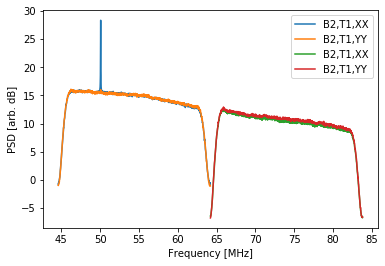

In [10]:
%matplotlib inline
# Get the metadata
b = idfS.get_info('beam')
dp = idfS.get_info('data_products')

# Compute the frequency bins
freq = numpy.fft.fftfreq(dataS.shape[2], d=1.0/idfS.get_info('sample_rate'))
freq = numpy.fft.fftshift(freq)
freq1 = freq + idfS.get_info('freq1')
freq2 = freq + idfS.get_info('freq2')

# Intgrate
spec = dataS.mean(axis=1)

# Plot
fig = plt.figure()
ax = fig.gca()
ax.plot(freq1/1e6, to_dB(spec[0,:]), label='B%i,T1,%s' % (b, dp[0 % len(dp)]))
ax.plot(freq1/1e6, to_dB(spec[1,:]), label='B%i,T1,%s' % (b, dp[1 % len(dp)]))
ax.plot(freq2/1e6, to_dB(spec[2,:]), label='B%i,T1,%s' % (b, dp[2 % len(dp)]))
ax.plot(freq2/1e6, to_dB(spec[3,:]), label='B%i,T1,%s' % (b, dp[3 % len(dp)]))
ax.set_xlabel('Frequency [MHz]')
ax.set_ylabel('PSD [arb. dB]')
ax.legend(loc=0)
plt.show()

# Offsetting

The LDP handlers also provide an easy-to-use mechanism to skip forward within a data file using the offset() method.  This method takes an offset in seconds and adjusts the location of the read() method within the file accordingly.  For example:

In [11]:
# Offset 10 ms into the file from the current location
skip = idfD.offset(0.010)
print("Skipped: %.3f ms" % (skip*1e3,))

# Read in another 50 ms of data
duration2, tStart2, data2 = idfD.read(0.050)
print("Duration read: %.3f ms" % (duration*1e3,))
print("Time of first sample: %.6f" % tStart)
print("Data specifics:", data.shape, data.dtype)
print(" ")
print("Time skip: %.3f ms" % ((tStart2-tStart)*1e3,))

Skipped: 10.240 ms
Duration read: 10.031 ms
Time of first sample: 1324515670.601744
Data specifics: (4, 196608) complex64
 
Time skip: 20.271 ms


At any point you can also skip back to the beginning of the file using the reset() method.

In [12]:
# Go back to the beginning
idfD.reset()

# Read in the first 10 ms again
duaration3, tStart3, data3 = idfD.read(0.010)

# Are the start times the same?
print("Back to the start?", True if tStart3-tStart == 0 else False)

# Are the data the same?
print("Back to the start?", True if (numpy.abs(data-data3)**2).sum() == 0 else False)

Back to the start? True
Back to the start? True


# Closing

When you are done using an LDP instance, just close it out:

In [13]:
idfD.close()
idfS.close()
idfN.close()
idfW.close()

Once a LDP instance is closed you will not be able to access the data in the file:

In [14]:
try:
    idfD.read(0.010)
except Exception as e:
    print("ERROR: %s" % str(e))

ERROR: I/O operation on closed file


# Additional Info
In addition to the modules provided in LSL there are also a variety of scripts in the [commissioning repo](https://github.com/lwa-project/commissioning) to analyze data.
